In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from math import sqrt, exp
from copy import deepcopy

Historical Simulation (Ex Post):
```
Historical Simulation estimates VaR by directly using historical data without making distributional assumptions.
Ex post weights are used because the calculation is based on observed historical returns and their associated weights during the observation period.
The weights are determined retrospectively based on actual portfolio compositions and returns realized over the historical period.
```

Parametric VaR (Ex Ante):
```
Parametric VaR relies on a specific distributional assumption for asset returns, such as a normal distribution.
Ex ante weights are used because the calculation of Parametric VaR assumes a known portfolio composition and weights based on forecasts or planned allocations before the actual returns are observed.
The weights are predetermined based on the portfolio's structure and are not adjusted based on realized returns during the observation period.
```

Monte Carlo Simulation (Ex Post):
```
Monte Carlo Simulation generates future scenarios based on specified probability distributions and model parameters.
Ex post weights are typically used because the simulation generates scenarios based on historical data and does not assume a specific distribution for returns.
The weights are determined based on actual portfolio compositions and returns observed in the historical data used to calibrate the simulation model.
```

In [2]:
df_stocks = pd.read_csv('portfolio_data.csv').set_index('Date')
df_stocks.index = pd.to_datetime(df_stocks.index)

In [3]:
df_stocks

,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-01,248.229996,51.190983,106.250000,30.415714
2013-05-02,252.550003,51.987320,98.099998,30.641428
2013-05-03,258.049988,52.446388,112.900002,30.492857
2013-05-06,255.720001,53.205257,109.599998,30.098572
2013-05-07,257.730011,54.151505,113.199997,29.464285
...,...,...,...,...
2019-05-08,1917.770020,283.149994,6171.959961,364.369995
2019-05-09,1899.869995,282.160004,6358.290039,362.750000
2019-05-10,1889.979980,278.369995,7191.359863,361.040009


In [4]:
# Portfolio Actual Returns
portfolio_returns = df_stocks.multiply(np.array([200,200,200,200]), axis='columns').sum(axis=1)
portfolio_returns1 = (portfolio_returns/portfolio_returns.shift(1)).dropna()
portfolio_log_returns = np.log(portfolio_returns1).dropna()

In [5]:
df_log_returns = np.log((df_stocks/df_stocks.shift(1)).dropna()).dropna()
portfolio = pd.DataFrame(index=df_log_returns.index)

## Historical Simulation to calculate VaR

In [6]:
# For Historical Simulation we use Ex Post Weights (Weights float from 1st day)
var_list = [np.nan] * 249
es_list = [np.nan] * 249
log_returns = portfolio_log_returns
for i in range(250,len(log_returns)+1):
    window_log_returns = log_returns.iloc[i-250:i]
    VaR = window_log_returns.quantile(0.01)
    log_returns_sorted = sorted(window_log_returns.values.tolist())
    length = len(log_returns_sorted)
    cutoff_rt1_index = math.floor(length*0.01 +1) - 1
    sum_rt1 = sum(log_returns_sorted[:cutoff_rt1_index])
    # Convert to arithmetric var
    var_list.append(exp(VaR)-1)
    es_list.append(exp(sum_rt1/len(log_returns_sorted[:cutoff_rt1_index]))-1)

In [7]:
portfolio['Hist_VaR'] = var_list
portfolio['Hist_ES'] = es_list

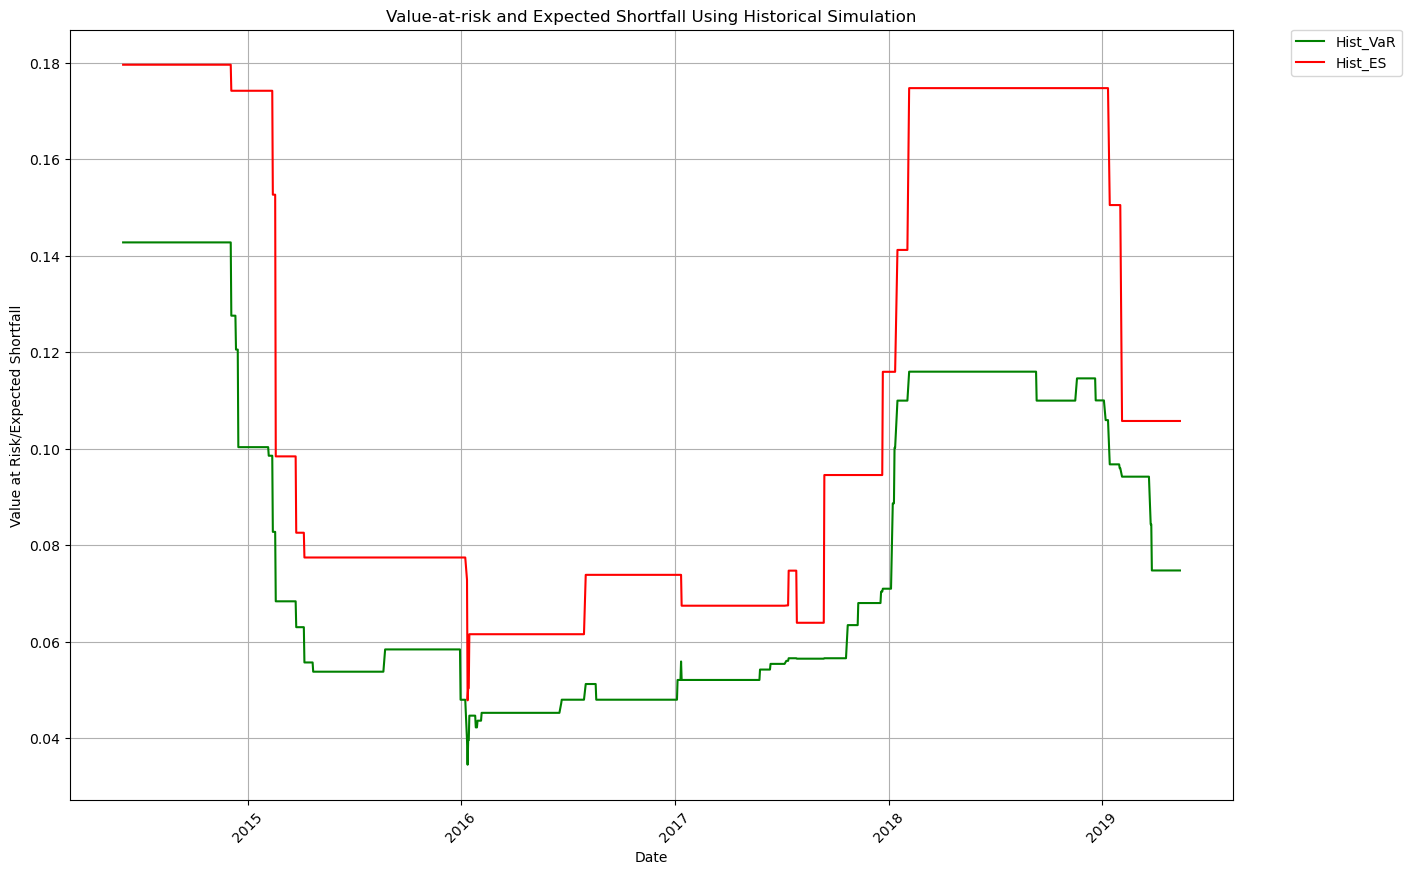

In [8]:
plt.figure(figsize=(15,10))
plt.plot(portfolio['2014-05-31':'2019-05-14'].index, -portfolio['2014-05-31':'2019-05-14']['Hist_VaR'], 'g-', label='Hist_VaR')
plt.plot(portfolio['2014-05-31':'2019-05-14'].index, -portfolio['2014-05-31':'2019-05-14']['Hist_ES'], 'r-', label='Hist_ES')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk/Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-risk and Expected Shortfall Using Historical Simulation')
plt.show()

## Parametric Var --> portfolio variance as w’Cw, where C is the covariance matrix

In [9]:
# For Para Var we use exante weights (Weights determined everyday)
log_returns = df_log_returns
var_list = [np.nan] * 249
es_list = [np.nan] * 249
alpha = 0.01
for i in range(250,len(log_returns)+1):
    window = log_returns.iloc[i-250:i]
    exante_value = df_stocks.iloc[i].values * [200, 200, 200, 200]
    exante_weights =  [a/sum(exante_value) for a in exante_value]
    window_log_mean = window.mean()
    window_returns = np.exp(window_log_mean.values) - 1
    window_mean_returns = np.dot(exante_weights,window_returns)
    window_log_returns = np.log(1 + window_mean_returns)
    window_weighted_mean = window_log_returns
    window_mat_df = window.values
    window_vcv = np.cov(window_mat_df.T)
    window_vcv_perc = np.exp(window_vcv) - 1
    window_variance_perc = np.dot(exante_weights, np.dot(window_vcv_perc, exante_weights))
    window_variance = np.log(window_variance_perc+1)
    window_vol = sqrt(window_variance)
    window_z_alpha = norm.ppf(alpha, loc=0, scale=1)
    window_var = window_weighted_mean + window_vol*window_z_alpha
    window_es = window_weighted_mean + (norm.pdf(window_z_alpha,0,1)*window_vol)/(alpha)
    # Convert to arithmetric var
    var_list.append(exp(window_var)-1)
    es_list.append((exp(-window_es)-1))

In [10]:
portfolio['Para_VaR'] = var_list
portfolio['Para_ES'] = es_list

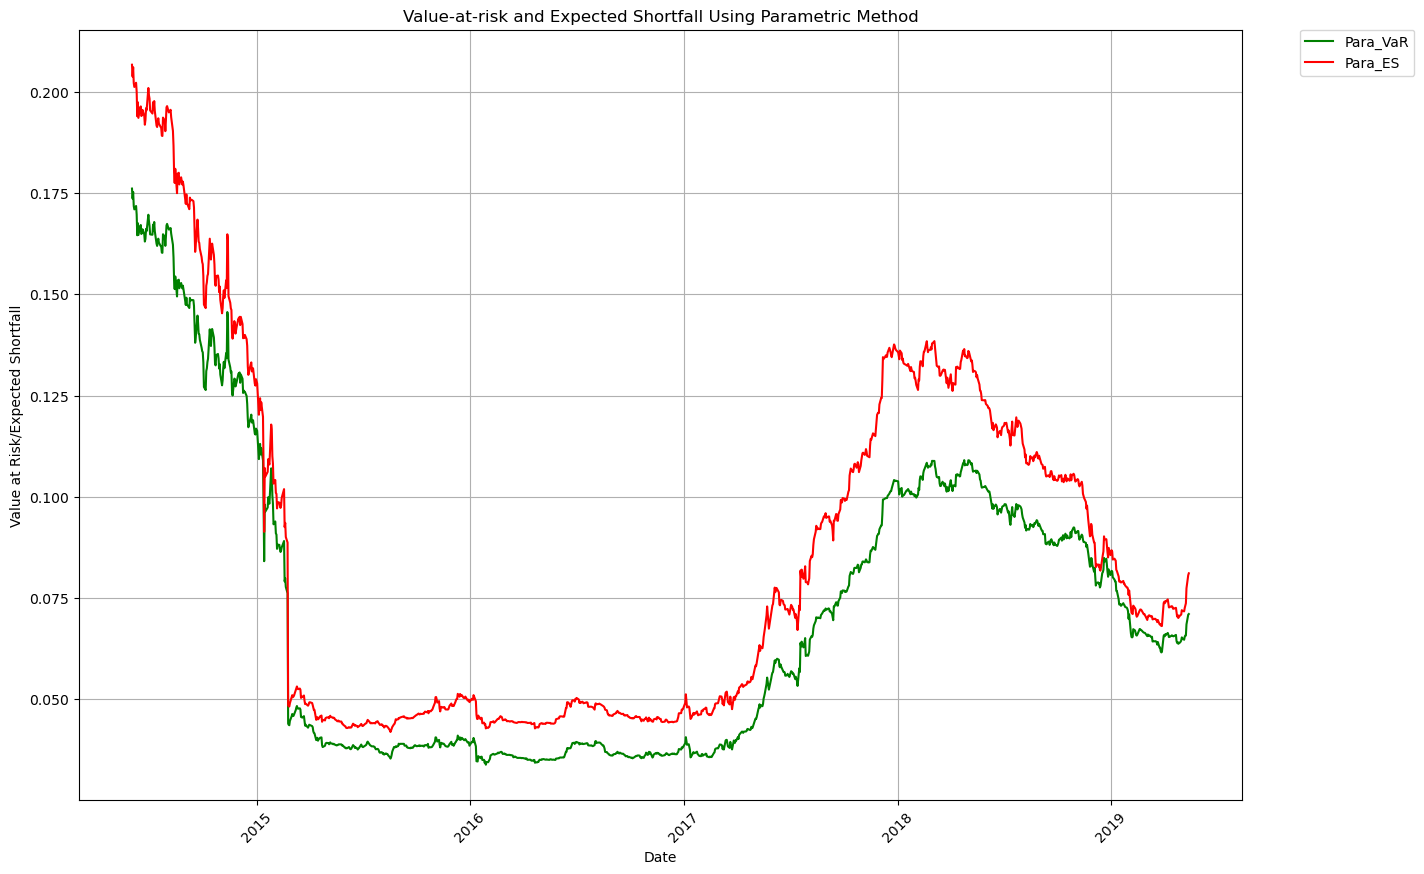

In [11]:
plt.figure(figsize=(15,10))
plt.plot(portfolio['2014-05-31':'2019-05-14'].index, -portfolio['2014-05-31':'2019-05-14']['Para_VaR'], 'g-', label='Para_VaR')
plt.plot(portfolio['2014-05-31':'2019-05-14'].index, -portfolio['2014-05-31':'2019-05-14']['Para_ES'], 'r-', label='Para_ES')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk/Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-risk and Expected Shortfall Using Parametric Method')
plt.show()

## Monte Carlo simulation method to estimate 1% VaR

In [12]:
# For Monte Carlo we use exposts weights
log_returns = portfolio_log_returns
np.random.seed(12345)
N_simulations = 10000
var_list = [np.nan] * 249
alpha = 0.01
for i in range(250,len(log_returns)+1):
    window = log_returns.iloc[i-250:i]
    window_weighted_mean = window.mean()
    window_vol = window.std()
    # QN 3 
    T = 1
    mu = (window_weighted_mean + (window_vol**2)/2)*T
    new_mu = (mu - (window_vol**2)/2)*T
    new_sterr = window_vol*sqrt(T)
    monte_log_returns = np.random.normal(loc=new_mu, scale=new_sterr, size=N_simulations)
    monte_log_returns = sorted(monte_log_returns, reverse=False)
    monte_var = monte_log_returns[int(N_simulations*alpha)]
    # Convert to arithmetric var
    var_list.append(exp(monte_var)-1)
portfolio['Monte_VaR'] = var_list

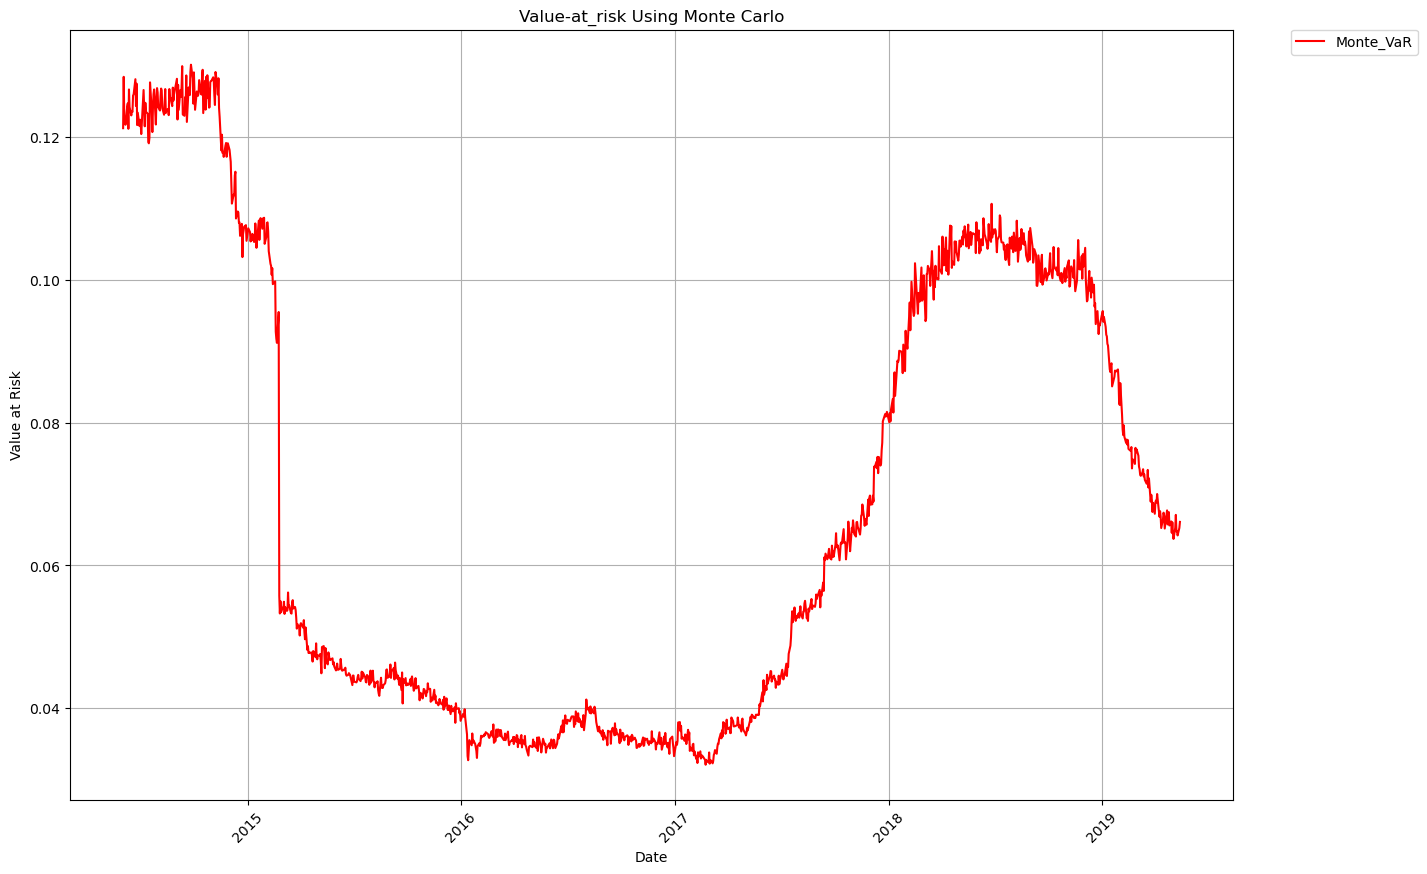

In [13]:
plt.figure(figsize=(15,10))
plt.plot(portfolio['2014-05-31':'2019-05-14'].index, -portfolio['2014-05-31':'2019-05-14']['Monte_VaR'], 'r-', label='Monte_VaR')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at_risk Using Monte Carlo')
plt.show()
#portfolio['Monte_VaR'].plot()

## Combining All Plots - VaR and ES

In [14]:
portfolio_plot = portfolio.loc['2014-05-31':'2019-05-14']

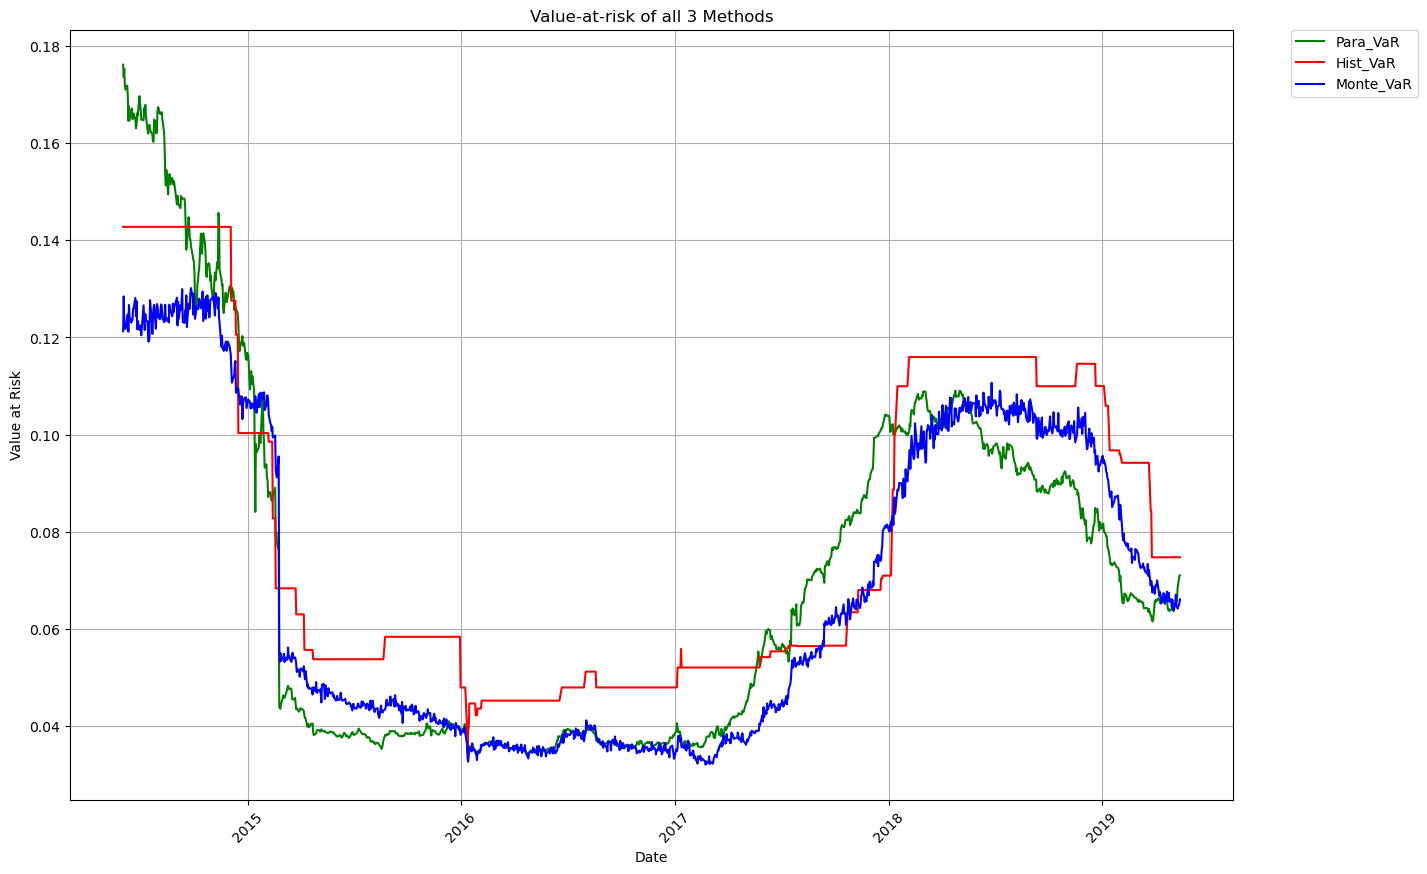

In [15]:
plt.figure(figsize=(15,10))
plt.plot(portfolio_plot.index, -portfolio_plot['Para_VaR'], 'g-', label='Para_VaR')
plt.plot(portfolio_plot.index, -portfolio_plot['Hist_VaR'], 'r-', label='Hist_VaR')
plt.plot(portfolio_plot.index, -portfolio_plot['Monte_VaR'], 'b-', label='Monte_VaR')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-risk of all 3 Methods')
plt.show()

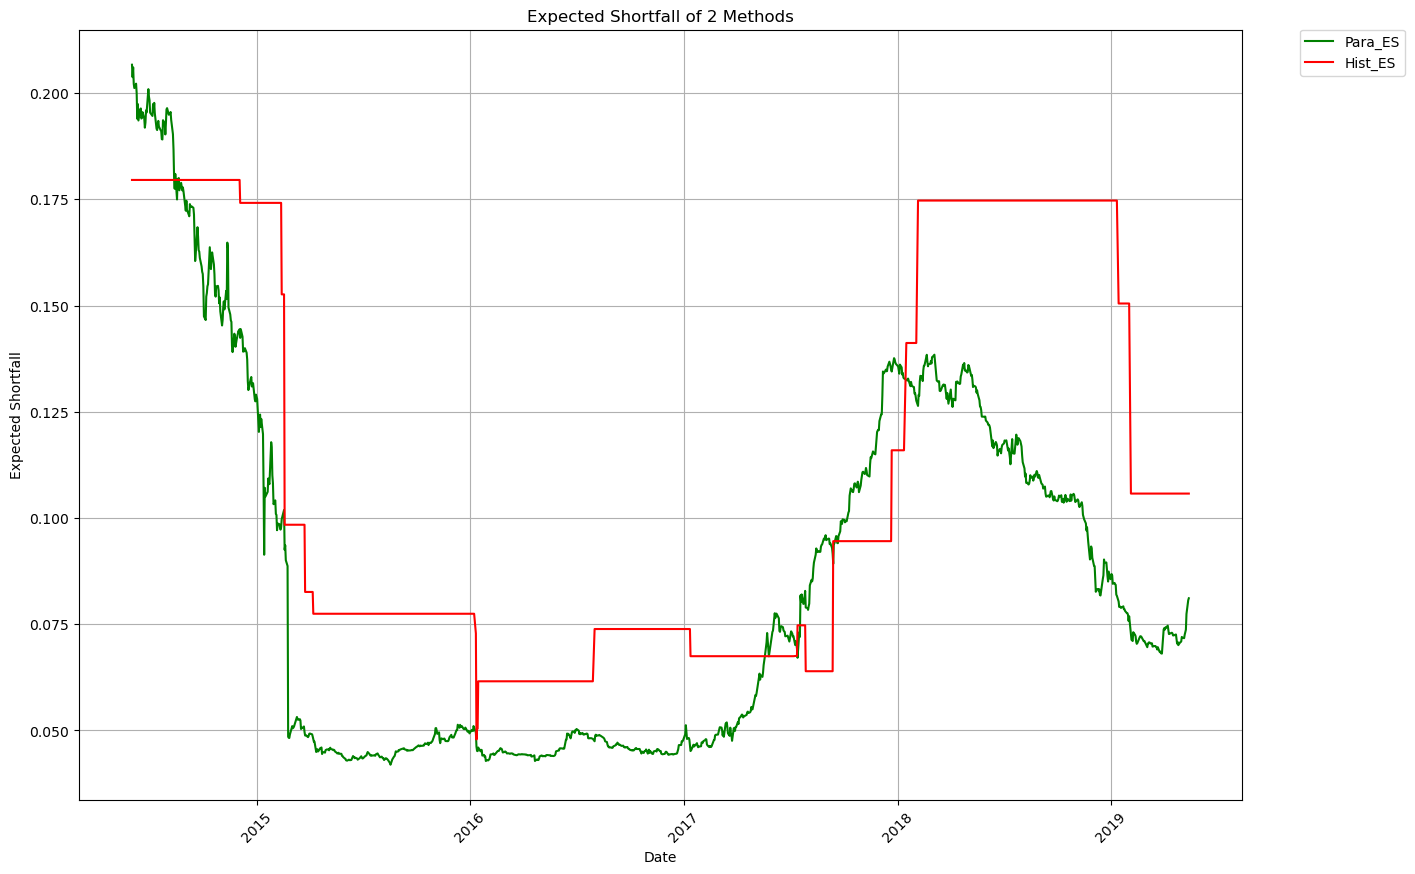

In [16]:
plt.figure(figsize=(15,10))
plt.plot(portfolio_plot.index, -portfolio_plot['Para_ES'], 'g-', label='Para_ES')
plt.plot(portfolio_plot.index, -portfolio_plot['Hist_ES'], 'r-', label='Hist_ES')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Expected Shortfall of 2 Methods')
plt.show()